#Importing libaries and Data Loading and Preprocessing.

**Importing Libraries**

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**Loading  the dataset**

In [3]:
covtype = fetch_covtype()
X, y = covtype.data, covtype.target

**The cover type labels are 1-based, convert to 0-based for consistent indexing with neural network output**

In [4]:
y = y - 1

**Split data**

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Indices 0-9**

In [6]:
numerical_features = slice(0, 10)

**Indices 10-53**

In [7]:
categorical_features = slice(10, 54)

**Normalize**

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Create preprocessor to scale numerical and one-hot encode categorical features**

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

**Preprocessing**

In [10]:
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

**Number of features after preprocessing**

In [11]:
input_size = x_train_processed.shape[1]
num_classes = len(np.unique(y_train))

In [12]:
print(f"Number of features after preprocessing: {input_size}")
print(f"Number of classes: {num_classes}")

Number of features after preprocessing: 98
Number of classes: 7


**Now labels to categorical (one-hot encoding) for the MLP**

In [13]:
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

**Display some example labels**

In [14]:
print("Example training labels:", y_train[1:10])

Example training labels: [1 6 0 4 0 1 1 1 1]


**Display class distribution**

In [15]:
print("Training data class distribution:", np.unique(y_train, return_counts=True))

Training data class distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([169472, 226640,  28603,   2198,   7594,  13894,  16408]))


The input size is already determined after preprocessing

In [16]:
print(f"Input size after preprocessing: {input_size}")

Input size after preprocessing: 98


In [17]:
def build_deeper_wider_model(input_size, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),          # Added Batch Normalization
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

deeper_wider_model = build_deeper_wider_model(input_size, num_classes)
deeper_wider_model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
deeper_wider_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,495 (498.03 KB)

 Trainable params: 126,215 (493.03 KB)

 Non-trainable params: 1,280 (5.00 KB)

**Experimenting with Different Activation Functions**

In [18]:
def build_leakyrelu_model(input_size, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(128),
        LeakyReLU(alpha=0.01), # Using LeakyReLU
        layers.Dense(128),
        LeakyReLU(alpha=0.01),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

leakyrelu_model = build_leakyrelu_model(input_size, num_classes)
leakyrelu_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
leakyrelu_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,087 (117.53 KB)

 Trainable params: 30,087 (117.53 KB)

 Non-trainable params: 0 (0.00 B)

# REGULARIZATION TECHNIQUES

In [19]:
def build_dropout_model(input_size, num_classes, dropout_rate=0.3):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

dropout_model = build_dropout_model(input_size, num_classes, dropout_rate=0.4) # Experimenting with a different dropout rate
dropout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dropout_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │        50,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,935 (1.21 MB)

 Trainable params: 316,935 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

**Adding L2 Regularization**

In [20]:
def build_l2_regularized_model(input_size, num_classes, l2_lambda=0.001):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

l2_regularized_model = build_l2_regularized_model(input_size, num_classes, l2_lambda=0.0005) # Experimenting with a different L2 lambda
l2_regularized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
l2_regularized_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │        50,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,935 (1.21 MB)

 Trainable params: 316,935 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

# OPTIMIZER AND LEARNING RATE STRATEGY

**Trying Multiple Optimizers**

In [21]:
def build_optimizer_model(input_size, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

optimizers = {
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9)
}

histories_optimizer = {}

for name, optimizer in optimizers.items():
    print(f"Training with optimizer: {name}")
    model_opt = build_optimizer_model(input_size, num_classes)
    model_opt.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model_opt.fit(x_train_processed, y_train_cat,
                           epochs=30,
                           validation_split=0.2,
                           batch_size=128,
                           verbose=0,
                           callbacks=[early_stopping])

    histories_optimizer[name] = history

Training with optimizer: Adam
Training with optimizer: RMSprop
Training with optimizer: SGD_momentum


**Plotting optimizer comparisons**

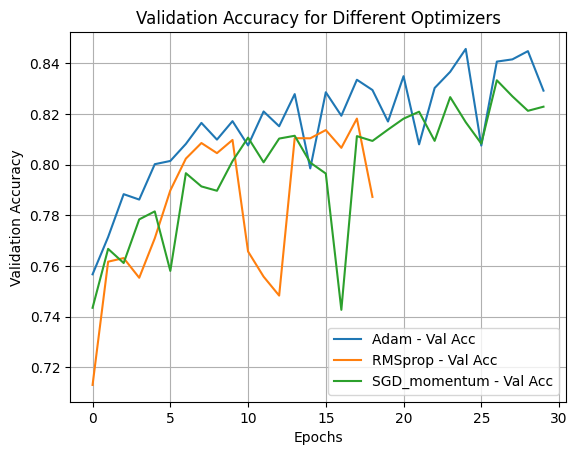

In [22]:
def plot_learning_curves(history, title=None):
    plt.figure(figsize=(14, 5))
for label, history in histories_optimizer.items():
    plt.plot(history.history['val_accuracy'], label=f'{label} - Val Acc')

plt.title("Validation Accuracy for Different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Using Learning Rate Scheduling (ReduceLROnPlateau)**

In [23]:
def build_lr_schedule_model(input_size, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_lr_schedule = build_lr_schedule_model(input_size, num_classes)
optimizer_lr_schedule = tf.keras.optimizers.Adam(learning_rate=0.001) # Start with a default learning rate
model_lr_schedule.compile(optimizer=optimizer_lr_schedule,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

early_stopping_lr = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increased patience for scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001) # Reduce LR when val_loss plateaus

history_lr_schedule = model_lr_schedule.fit(x_train_processed, y_train_cat,
                                            epochs=50, # More epochs to see scheduling effect
                                            validation_split=0.2,
                                            batch_size=128,
                                            verbose=1,
                                            callbacks=[early_stopping_lr, reduce_lr])

plot_learning_curves(history_lr_schedule, title='Model with LR Scheduling')

Epoch 1/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7084 - loss: 0.6898 - val_accuracy: 0.7596 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 2/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7637 - loss: 0.5495 - val_accuracy: 0.7777 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 3/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7778 - loss: 0.5149 - val_accuracy: 0.7849 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 4/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7872 - loss: 0.4927 - val_accuracy: 0.7910 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 5/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7935 - loss: 0.4792 - val_accuracy: 0.7998 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 6/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8002 - loss: 0.4656 - val_accuracy: 0.8017 - val_loss: 0.4665 - learning_rate: 0.0010
Epoch 7/50
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8056 

<Figure size 1400x500 with 0 Axes>

# MODEL EVALUATION

** Evaluating the final chosen MLP model using comprehensive metrics.**

In [24]:
print("Evaluating Final MLP Model (with LR Scheduling)")


Evaluating Final MLP Model (with LR Scheduling)


**Make predictions**

In [25]:
mlp_preds = model_lr_schedule.predict(x_test_processed).argmax(axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [26]:
print("\nMLP Classification Report:")
print(classification_report(y_test, mlp_preds))


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     42368
           1       0.86      0.90      0.88     56661
           2       0.85      0.86      0.85      7151
           3       0.74      0.83      0.78       549
           4       0.69      0.59      0.64      1899
           5       0.73      0.70      0.72      3473
           6       0.89      0.88      0.88      4102

    accuracy                           0.86    116203
   macro avg       0.80      0.80      0.80    116203
weighted avg       0.86      0.86      0.86    116203



**Calculate Precision, Recall, F1-score (macro and weighted)**

In [27]:
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, mlp_preds, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test, mlp_preds, average='weighted')

print(f"\nMacro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"\nWeighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")


Macro Precision: 0.8046
Macro Recall: 0.7993
Macro F1-score: 0.8008

Weighted Precision: 0.8603
Weighted Recall: 0.8604
Weighted F1-score: 0.8597


**Confusion Matrix**

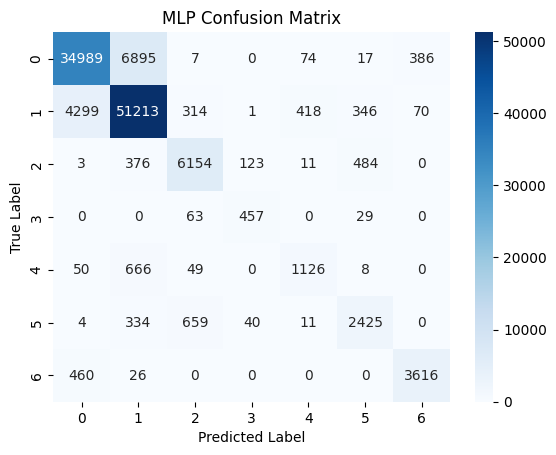

In [28]:
sns.heatmap(confusion_matrix(y_test, mlp_preds), annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Visualized learning curves (already plotted during training)

**Train and Evaluate Random Forest Classifier**

In [29]:
print("Training and Evaluating Random Forest Classifier")
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

Training and Evaluating Random Forest Classifier


**Train on processed data**

In [30]:
rf.fit(x_train_processed, y_train)
rf_preds = rf.predict(x_test_processed)

In [31]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.94      0.97      0.96     56661
           2       0.93      0.96      0.95      7151
           3       0.92      0.84      0.88       549
           4       0.95      0.76      0.84      1899
           5       0.93      0.88      0.90      3473
           6       0.97      0.94      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.94      0.90      0.92    116203
weighted avg       0.95      0.95      0.95    116203



**Calculate Precision, Recall, F1-score**

In [32]:
precision_macro_rf, recall_macro_rf, f1_macro_rf, _ = precision_recall_fscore_support(y_test, rf_preds, average='macro')
precision_weighted_rf, recall_weighted_rf, f1_weighted_rf, _ = precision_recall_fscore_support(y_test, rf_preds, average='weighted')

In [33]:
print(f"\nMacro Precision: {precision_macro_rf:.4f}")
print(f"Macro Recall: {recall_macro_rf:.4f}")
print(f"Macro F1-score: {f1_macro_rf:.4f}")
print(f"\nWeighted Precision: {precision_weighted_rf:.4f}")
print(f"Weighted Recall: {recall_weighted_rf:.4f}")
print(f"Weighted F1-score: {f1_weighted_rf:.4f}")


Macro Precision: 0.9440
Macro Recall: 0.8983
Macro F1-score: 0.9192

Weighted Precision: 0.9499
Weighted Recall: 0.9497
Weighted F1-score: 0.9494


**Confusion Matrix**

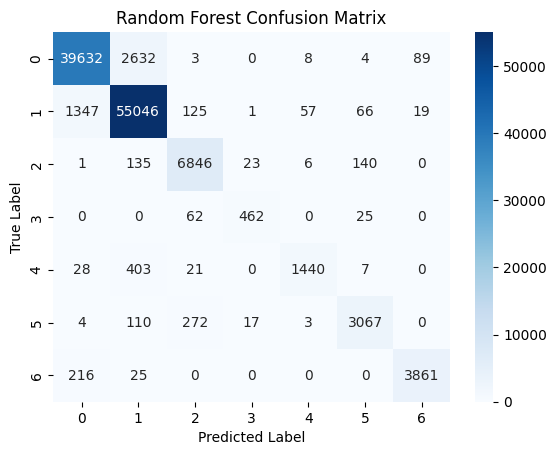

In [34]:
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Reflection based on the current Experiments.

Tree-based ensemble methods like Random Forest often outperform MLPs on structured/tabular datasets because they naturally handle feature interactions and do not require intensive normalization. They are robust to outliers and can manage categorical and numerical features effectively. MLPs, while powerful, typically demand more careful tuning and benefit less from the structure of tabular data compared to trees.